In [1]:
import torch as t
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import CIFAR10
import numpy as np
from torch  import optim
import torchvision.utils as vutil
from tensorboard_logger import Logger
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import default_collate
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorboard_logger import configure, log_value, Logger

In [2]:
class DefaultConfig:
        
    # DO NOT MODIFY HERE
    lr=2e-4
    nz=100# 噪声维度
    image_size=64
    image_size2=64
    nc=3# 图片三通道
    ngf=64 #生成图片
    ndf=64 #判别图片
    gpuids=2 # GPU 数目
    beta1=0.5  #
    batch_size=256　
    max_epoch=120# =1 when debug
    workers=4
    clamp_num=0.01# WGAN 截断大小
class Config(DefaultConfig):
    # OVERWRIGHT HERE
    pass

opt=Config()

In [3]:
#  数据加载
class MyImageFolder(ImageFolder):
    '''
    复写ImageFolder 因为有些图片有问题,
    有问题的图片就返回None
    '''
    __init__ = ImageFolder.__init__
    def __getitem__(self, index):
        try: 
            return super(MyImageFolder, self).__getitem__(index) 
        except Exception as e:
            print e

val_dataset = MyImageFolder('/home/x/data/pre/train_new/nouse',
                transform=transforms.Compose(\
                                             
                                             [transforms.Scale(opt.image_size),
                                              transforms.RandomCrop(opt.image_size) ,
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.5]*3,[0.5]*3)
                                             ]))

def my_collate(batch):
    '''
    过滤掉为None的数据
    '''
    batch = filter (lambda x:x is not None, batch)
    return default_collate(batch)

val_dataloader=t.utils.data.DataLoader(val_dataset,opt.batch_size,True,num_workers=opt.workers, collate_fn=my_collate)

In [4]:
# 网络结构 定义 
torch = t
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial.{0}-{1}.convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial.{0}.batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial.{0}.relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid.{0}-{1}.convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid.{0}.relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final.{0}-{1}.convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final.{0}.tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        return nn.parallel.data_parallel(self.main, input, gpu_ids)

class DCGAN_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial.conv.{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial.relu.{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid.{0}.relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final.{0}-{1}.conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        output = nn.parallel.data_parallel(self.main, input, gpu_ids)
        output = output.mean(0)
        return output.view(1)


In [6]:
netG = DCGAN_G(opt.image_size, opt.nz, opt.nc, opt.ngf, opt.gpuids, 1)
netD = DCGAN_D(opt.image_size, opt.nz, opt.nc, opt.ndf,opt.gpuids,1)
def weight_init(m):
    # 参数初始化。 可以改成xavier初始化方法
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:       
        m.weight.data.normal_(0,0.02)
    if class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
        m.bias.data.fill_(0)
netG.apply(weight_init)
netD.apply(weight_init)
netG.cuda()
netD.cuda()

DCGAN_D (
  (main): Sequential (
    (initial.conv.3-64): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial.relu.64): LeakyReLU (0.2, inplace)
    (extra-layers-0.64.conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (extra-layers-0.64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (extra-layers-0.64.relu): LeakyReLU (0.2, inplace)
    (pyramid.64-128.conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.128.relu): LeakyReLU (0.2, inplace)
    (pyramid.128-256.conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.256.relu): LeakyReLU (0.2, inplace)
    (pyramid.256-512.conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), paddi

In [10]:
# 训练
netd = netD
netg = netG
optimizerD=optim.RMSprop(netd.parameters(),lr=opt.lr*0.1 ) #modify ： 不要采用基于动量的优化方法 如Adam
optimizerG=optim.RMSprop(netg.parameters(),lr=opt.lr*0.1 )  #  

#criterion=nn.BCELoss() # WGAN 不需要log（交叉熵） 
one=t.FloatTensor([1])
mone=-1*one

noise=Variable(t.FloatTensor(opt.batch_size,opt.nz,1,1).cuda()) 
fixed_noise=Variable(t.cuda.FloatTensor(64,opt.nz,1,1).normal_(0,1)) 

test_logger = Logger('tensorboard_log/runs/dcsb_4')


for epoch in xrange(150,280):
    try:
     for ii, data in enumerate(val_dataloader,0):
        #### 训练D网 ####
        if True :
            netd.zero_grad() 
            real,_=data
            input=Variable(real).cuda()
            output=netd(input)
            test_logger.log_value('errorD_real', output.data[0])
            output.backward(one)#######for wganut
            D_x=output.data.mean()

            noise.data.resize_(input.size()[0],opt.nz,1,1 ).normal_(0,1)
            #　Volatile = True 可以加快netg的计算, 减少内存占用
            fake_pic = netg(Variable(noise.data, volatile = True)) 
            output2 = netd(Variable(fake_pic.data))
            if epoch>0:test_logger.log_value('errorD_fake', output2.data[0])
            if epoch>0:test_logger.log_value('errorD_',output.data[0] - output2.data[0])


            output2.backward(mone) #for wgan
            D_x2=output2.data.mean()        
            optimizerD.step()
            
            test_logger.log_value('D_X2',D_x2) #判别器对假样本的平均给分
            if epoch>0:test_logger.log_value('D_x',D_x) #判别器给真图片的平均给分
            
            for parm in netd.parameters():parm.data.clamp_(-opt.clamp_num,opt.clamp_num) ### WGAN:判别器需要 截断参数


        # d网和g网的训练次数不一样, 这里d网和g网的训练比例大概是: 5:1
        if ii%5 ==0   :
            netg.zero_grad()
            noise.data.normal_(0,1)
            fake_pic=netg(noise)
            output=netd(fake_pic)
            output.backward(one)
            if epoch>0:test_logger.log_value('error_G',output.data[0])
            optimizerG.step()
            D_G_z2=output.data.mean()
            if epoch>0:test_logger.log_value('D_G_z2', D_G_z2)      

        if ii%100==0 and ii>0 and True:
            # 保存生成的图片
            fake_u=netg(fixed_noise)
            vutil.save_image(fake_u.data,'20170306/dcsb/fake1_%s_%s.png'%(epoch,ii))
            test_logger.log_value('epoch_ii', ii)
#学习率的衰减
#      if epoch%50 == 49: 
#             n__ = epoch/50 -1
#             optimizerD=optim.RMSprop(netd.parameters(),lr=opt.lr*(0.1**n__) ) 
#             optimizerG=optim.RMSprop(netg.parameters(),lr=opt.lr*(0.1**n__) )
     t.save(netd.state_dict(),'20170306/bad_netd_%s_epotch.pth' %epoch)
     t.save(netg.state_dict(),'20170306/bad_netg_%s_epotch.pth' %epoch)
     test_logger.log_value('epoch_n', epoch)
     
    except Exception as e:
        print e

/usr/local/lib/python2.7/dist-packages/PIL/Image.py:874: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:874: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:874: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:874: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:874: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:874: UserWarning: Palette images with Transparency   

KeyboardInterrupt: 

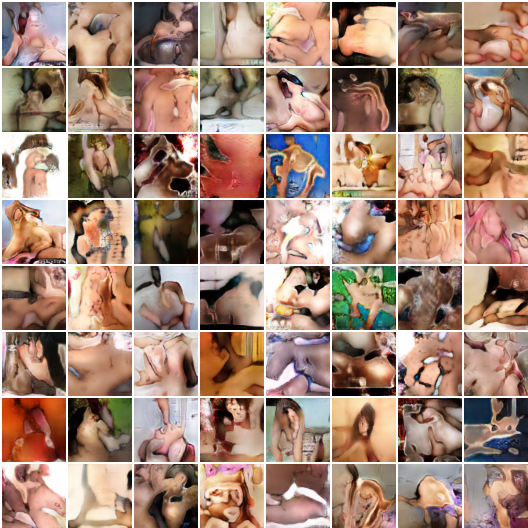

In [2]:
from IPython.display import Image
Image('image/fake1_244_300.png')

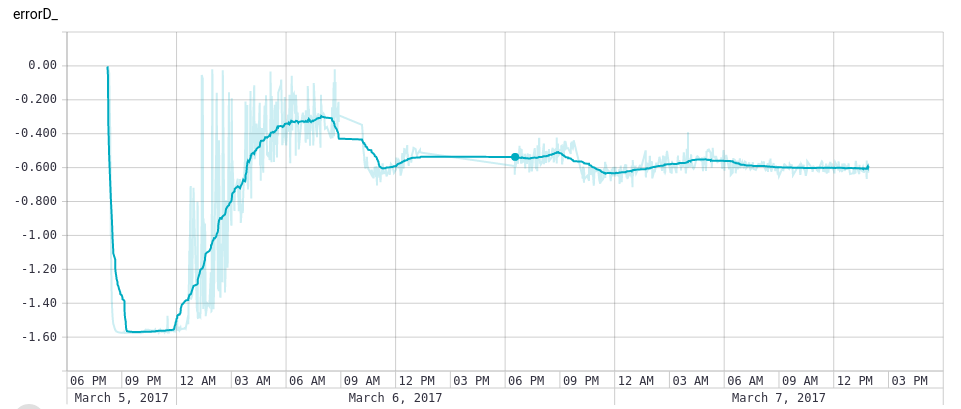

In [3]:
Image('image/errorD.png')

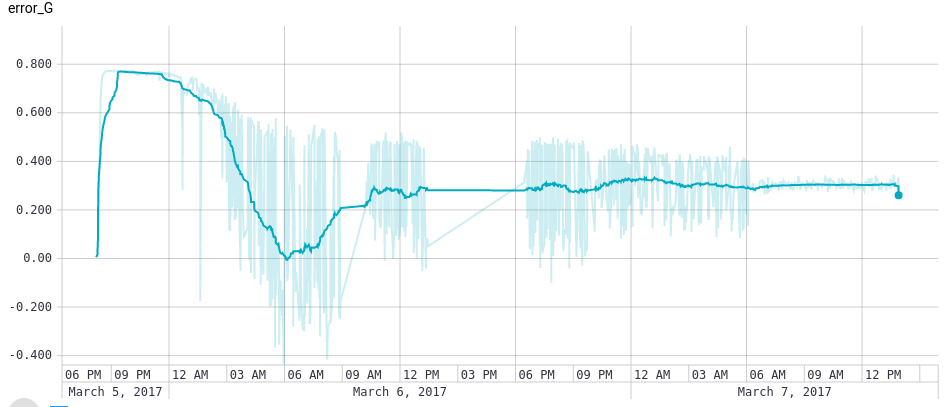

In [4]:
Image('image/errorG.png')